In [1]:
import sys


sys.path.append("../..")


from cfbpy import plays


import numpy as np


import pandas as pd

In [2]:
# df = plays.get_plays(years=[2021, 2022], weeks=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
# df.to_parquet("df_raw.parquet")

In [3]:
import polars as pl

In [4]:
df = pl.scan_parquet("df_raw.parquet")

In [5]:
df = pd.read_parquet("df_raw.parquet")

In [6]:
df = plays.add_features(df)

Filter non-plays and kickoffs

In [8]:
df = df[~df.play_type.isin(plays.NON_PLAY)]
df = df[~df.play_type.isin(plays.KICKOFFS)]
df = df.reset_index(drop=True)

Score/margin are post-play, so need lagging score/margin.

In [10]:
# Get previous n playcalls as features
df["pass_lag_1"] = df.groupby("offense")["pass"].shift(1, fill_value=0)
df["pass_lag_2"] = df.groupby("offense")["pass"].shift(2, fill_value=0)
df["pass_lag_3"] = df.groupby("offense")["pass"].shift(3, fill_value=0)
df["pass_lag_4"] = df.groupby("offense")["pass"].shift(4, fill_value=0)
df["pass_lag_5"] = df.groupby("offense")["pass"].shift(5, fill_value=0)
df["rush_lag_1"] = df.groupby("offense")["rush"].shift(1, fill_value=0)
df["rush_lag_2"] = df.groupby("offense")["rush"].shift(2, fill_value=0)
df["rush_lag_3"] = df.groupby("offense")["rush"].shift(3, fill_value=0)
df["rush_lag_4"] = df.groupby("offense")["rush"].shift(4, fill_value=0)
df["rush_lag_5"] = df.groupby("offense")["rush"].shift(5, fill_value=0)

In [11]:
X = df[
    [
        "year",
        "week",
        "presnap_offense_score",
        "presnap_defense_score",
        "presnap_offense_margin",
        "pass_lag_1",
        "pass_lag_2",
        "pass_lag_3",
        "pass_lag_4",
        "pass_lag_5",
        "rush_lag_1",
        "rush_lag_2",
        "rush_lag_3",
        "rush_lag_4",
        "rush_lag_5",
        "down",
        "distance",
        "yards_to_goal",
        "period",
        "offense_timeouts",
        "defense_timeouts",
        "clock_in_seconds",
        "pass",
        "rush",
    ]
]

In [12]:
X = X.dropna()

X = X.sample(frac=1)

<Axes: xlabel='presnap_offense_margin'>

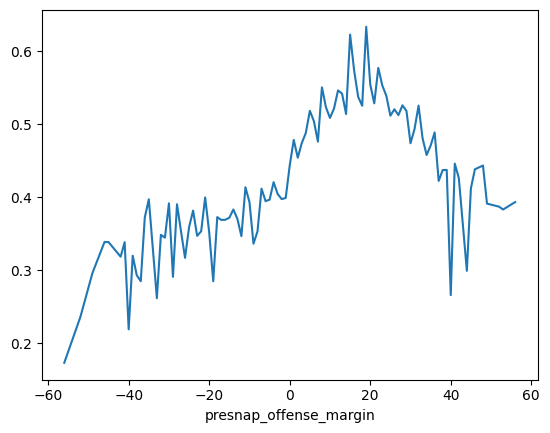

In [14]:
X.groupby("presnap_offense_margin")["pass"].agg(["sum", "count"]).assign(
    rate=lambda df: df["sum"] / df["count"]
).pipe(lambda df: df[df["count"] > 100])["rate"].plot()

In [15]:
X_train = X[X["year"] <= 2021]
X_test = X[X["year"] == 2022]

In [16]:
X_train.shape, X_test.shape

((113525, 24), (115769, 24))

In [17]:
import lightgbm as lgbm
from sklearn.ensemble import RandomForestClassifier as rfc
from sklearn.ensemble import HistGradientBoostingClassifier as hgbc

In [18]:
TRAIN_COLS = [
    "presnap_offense_margin",
    "presnap_offense_score",
    "presnap_defense_score",
    "down",
    "distance",
    "yards_to_goal",
    "period",
    "offense_timeouts",
    "defense_timeouts",
    "clock_in_seconds",
]

In [19]:
y_train, y_test = X_train[["pass", "rush"]], X_test[["pass", "rush"]]
X_train = X_train[TRAIN_COLS]
X_test = X_test[TRAIN_COLS]

In [20]:
import math

train_rows = math.floor(len(X_train) * 0.75)
X_train, X_valid = X_train.iloc[0:train_rows, :], X_train.iloc[train_rows:, :]
y_train, y_valid = y_train.iloc[0:train_rows, :], y_train.iloc[train_rows:, :]

In [21]:
from sklearn.metrics import log_loss, accuracy_score

# Training

## Base classifier to beat

In [22]:
model = rfc(
    random_state=0,
    oob_score=True,
    n_jobs=-1,
    n_estimators=1000,
    max_depth=5,
)

In [23]:
model.fit(X=X_train, y=y_train["pass"])

RandomForestClassifier(max_depth=5, n_estimators=1000, n_jobs=-1,
                       oob_score=True, random_state=0)

In [24]:
model.oob_score_

0.6480509260890502

3-week sample oob-score: 64.5

12-week sample oob-score w/ feature engineering updates: 64.8

In [25]:
log_loss(y_true=y_valid["pass"], y_pred=model.predict_proba(X_valid)[:, 1])

0.6144864863858236

In [26]:
accuracy_score(y_true=y_valid["pass"], y_pred=model.predict(X_valid))

0.648086815587344

<Axes: xlabel='bucket'>

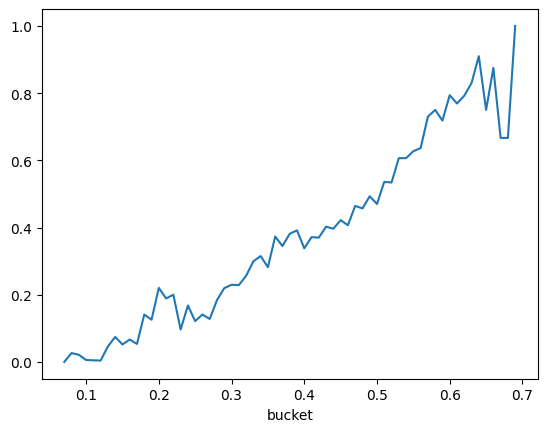

In [27]:
pd.DataFrame(
    {"actual": y_valid["pass"], "pred": model.predict_proba(X_valid)[:, 1]}
).assign(bucket=lambda df: round(df["pred"], 2)).groupby("bucket")[
    "actual"
].mean().plot()

In [43]:
# Model
model = lgbm.LGBMClassifier(
    # constants
    boosting_type="gbdt",
    learning_rate=0.01,
    n_estimators=2000,
    objective="binary",
    random_state=0,
    early_stopping_round=10,
    # tuned
    reg_alpha=3.9740293140705107,
    reg_lambda=1.881540488130314,
    colsample_bytree=0.7,  # percent of features to randomly select for use on each tree
    subsample=0.9,  # percent of data to sample without resampling. only works if bagging_freq is also set
    bagging_freq=1,  # bag by subsample every kth tree
    max_depth=6,
    num_leaves=20,  # should be less than 2^max_depth. Should be significantly less to avoid overfitting
    min_child_samples=10,
    # meta
    force_col_wise=True,
    n_jobs=-1,
)

model.fit(
    X=X_train,
    y=y_train["pass"],
    eval_set=(X_valid, y_valid["pass"]),
)

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Number of positive: 37937, number of negative: 47206
[LightGBM] [Info] Total Bins 698
[LightGBM] [Info] Number of data points in the train set: 85143, number of used features: 10
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.445568 -> initscore=-0.218594
[LightGBM] [Info] Start training from score -0.218594
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1919]	valid_0's binary_logloss: 0.573838


LGBMClassifier(bagging_freq=1, colsample_bytree=0.7, early_stopping_round=10,
               force_col_wise=True, learning_rate=0.01, max_depth=6,
               min_child_samples=10, n_estimators=2000, n_jobs=-1,
               num_leaves=20, objective='binary', random_state=0,
               reg_alpha=3.9740293140705107, reg_lambda=1.881540488130314,
               subsample=0.9)

In [44]:
model.best_iteration_, model.best_score_["valid_0"]["binary_logloss"]

(1919, 0.5738382748545574)

# Eval

Feature Importance

In [45]:
feat_imp = pd.DataFrame(
    {"feat": model.feature_name_, "imp": model.feature_importances_}
).sort_values(by="imp", ascending=False)

In [47]:
feat_imp.head(20)

,feat,imp
9,clock_in_seconds,8064
5,yards_to_goal,6398
0,presnap_offense_margin,5615
4,distance,4358
2,presnap_defense_score,3140
3,down,2902
1,presnap_offense_score,2583
8,defense_timeouts,1308
7,offense_timeouts,1240
6,period,853


In [61]:
y_preds = model.predict(X_test)
y_preds = pd.Series(y_preds, name="preds")
eval_df = pd.DataFrame(
    {"preds": y_preds, "actual": y_test["pass"].reset_index(drop=True)}
)

test_acc = accuracy_score(y_true=eval_df["actual"], y_pred=eval_df["preds"])
test_acc

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


0.675750848672788

In [62]:
y_preds = model.predict_proba(X_test)[:, 1]
y_preds = pd.Series(y_preds, name="preds")
eval_df = pd.DataFrame(
    {"preds": y_preds, "actual": y_test["pass"].reset_index(drop=True)}
)

test_logloss = log_loss(y_true=eval_df["actual"], y_pred=eval_df["preds"])
test_logloss

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


0.5756044096438071

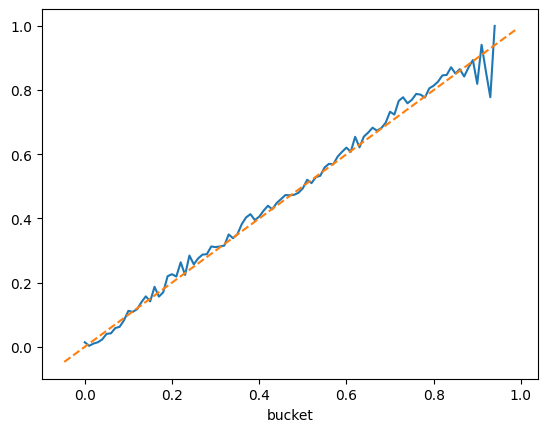

In [55]:
import matplotlib.pyplot as plt
import numpy as np


def abline(slope, intercept):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, "--")


eval_df.assign(bucket=lambda df: round(df["preds"], 2)).groupby("bucket")[
    "actual"
].mean().plot()
abline(1, 0)

Compare to straight up, ATS.

Log Model Results

In [59]:
from datetime import datetime

date = format(datetime.today(), "%Y-%m-%d-%H-%M")


model_name = f"model-{date}"

In [63]:
eval_dict = {
    "valid_logloss": model.best_score_["valid_0"]["binary_logloss"],
    "test_logloss": test_logloss,
    "test_accuracy": test_acc,
    "top_feats": feat_imp.head(10),
}

eval_dict

{'valid_logloss': 0.5738382748545574,
 'test_logloss': 0.5756044096438071,
 'test_accuracy': 0.675750848672788,
 'top_feats':                      feat   imp
 9        clock_in_seconds  8064
 5           yards_to_goal  6398
 0  presnap_offense_margin  5615
 4                distance  4358
 2   presnap_defense_score  3140
 3                    down  2902
 1   presnap_offense_score  2583
 8        defense_timeouts  1308
 7        offense_timeouts  1240
 6                  period   853}

In [67]:
from pathlib import Path

Path("./models/").mkdir(parents=True, exist_ok=True)

with open(f"./models/eval-{model_name}.txt", "w") as f:
    f.write(str(eval_dict))

# Hyperparam Tuning

In [77]:
iter = []

from sklearn.metrics import log_loss
from sklearn.model_selection import KFold


def objective(
    trial,
    X=X_train.reset_index(drop=True),
    y=y_train.reset_index(drop=True),
    data=None,
    target=None,
):
    param = {
        "metric": "binary_logloss",
        "random_state": 0,
        "n_estimators": 2000,
        "learning_rate": 0.01,
        "subsample_freq": 1,
        "early_stopping_rounds": 10,
        "force_col_wise": True,
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-3, 10.0, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-3, 10.0, log=True),
        "colsample_bytree": trial.suggest_categorical(
            "colsample_bytree", [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
        ),
        "subsample": trial.suggest_categorical(
            "subsample", [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
        ),
        "bagging_freq": trial.suggest_categorical("bagging_freq", [1, 2, 3, 5, 10]),
        "max_depth": trial.suggest_int("max_depth", 1, 9),
        "num_leaves": trial.suggest_int("num_leaves", 2, 1000),
        "min_child_samples": trial.suggest_int("min_child_samples", 1, 50),
    }
    model = lgbm.LGBMClassifier(**param, verbosity=-1)

    kf = KFold(n_splits=5, shuffle=True, random_state=0)
    avg_logloss = []
    avg_iter = []

    for i, (train_index, test_index) in enumerate(kf.split(X=X, y=y)):
        X_test, y_test = X.loc[test_index, :], y.loc[test_index, :]
        X_train, y_train = X.loc[train_index, :], y.loc[train_index, :]

        model.fit(
            X_train,
            y_train["pass"],
            eval_set=(X_valid, y_valid["pass"]),
        )

        avg_iter.append(model.best_iteration_)

        preds = model.predict_proba(X_test)[:, 1]

        logloss = log_loss(y_true=y_test["pass"], y_pred=preds)

        avg_logloss.append(logloss)

    # Avg. results over K folds
    avg_logloss = np.mean(avg_logloss)
    avg_iter = np.mean(avg_iter)

    # Save avg. number of rounds for reference
    iter.append(avg_iter)

    return avg_logloss

In [78]:
import optuna

study = optuna.create_study(direction="minimize", study_name="pass-run")


study.optimize(objective, n_trials=20)


print("Number of finished trials:", len(study.trials))


print("Best trial:", study.best_trial.params)

[I 2023-11-21 18:33:30,263] A new study created in memory with name: pass-run


[I 2023-11-21 18:33:50,235] Trial 0 finished with value: 0.5847777930436996 and parameters: {'reg_alpha': 0.096497407231596, 'reg_lambda': 0.09976350947532019, 'colsample_bytree': 0.9, 'subsample': 0.9, 'bagging_freq': 10, 'max_depth': 3, 'num_leaves': 265, 'min_child_samples': 44}. Best is trial 0 with value: 0.5847777930436996.
[I 2023-11-21 18:34:11,723] Trial 1 finished with value: 0.575187586339061 and parameters: {'reg_alpha': 0.6899287014523924, 'reg_lambda': 2.140528861912708, 'colsample_bytree': 0.9, 'subsample': 0.4, 'bagging_freq': 3, 'max_depth': 8, 'num_leaves': 897, 'min_child_samples': 46}. Best is trial 1 with value: 0.575187586339061.
[I 2023-11-21 18:34:24,280] Trial 2 finished with value: 0.5791174399520783 and parameters: {'reg_alpha': 0.036289273641112965, 'reg_lambda': 0.09709617381575378, 'colsample_bytree': 1.0, 'subsample': 0.2, 'bagging_freq': 10, 'max_depth': 6, 'num_leaves': 795, 'min_child_samples': 18}. Best is trial 1 with value: 0.575187586339061.
[I 202

Number of finished trials: 20
Best trial: {'reg_alpha': 2.2002764766987744, 'reg_lambda': 0.42984378942542767, 'colsample_bytree': 1.0, 'subsample': 0.8, 'bagging_freq': 3, 'max_depth': 7, 'num_leaves': 635, 'min_child_samples': 39}


In [79]:
study.best_value

0.574652030318154

In [80]:
assert test_logloss > study.best_value

In [81]:
best_iter = iter[study.best_trial.number]
best_iter

698.0

In [82]:
study.best_params

{'reg_alpha': 2.2002764766987744,
 'reg_lambda': 0.42984378942542767,
 'colsample_bytree': 1.0,
 'subsample': 0.8,
 'bagging_freq': 3,
 'max_depth': 7,
 'num_leaves': 635,
 'min_child_samples': 39}

# Retrain with updated hyperparams

In [83]:
# Model
model = lgbm.LGBMClassifier(
    # constants
    boosting_type="gbdt",
    learning_rate=0.01,
    n_estimators=2000,
    objective="binary",
    random_state=0,
    early_stopping_round=10,
    # tuned
    **study.best_params,
    # meta
    force_col_wise=True,
    n_jobs=-1,
)

model.fit(
    X=X_train,
    y=y_train["pass"],
    eval_set=(X_valid, y_valid["pass"]),
)

[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Info] Number of positive: 37937, number of negative: 47206
[LightGBM] [Info] Total Bins 698
[LightGBM] [Info] Number of data points in the train set: 85143, number of used features: 10
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.445568 -> initscore=-0.218594
[LightGBM] [Info] Start training from score -0.218594
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

LGBMClassifier(bagging_freq=3, early_stopping_round=10, force_col_wise=True,
               learning_rate=0.01, max_depth=7, min_child_samples=39,
               n_estimators=2000, n_jobs=-1, num_leaves=635, objective='binary',
               random_state=0, reg_alpha=2.2002764766987744,
               reg_lambda=0.42984378942542767, subsample=0.8)

## Confirm test results indeed improved

Score to beat

In [85]:
new_logloss = log_loss(y_true=y_test["pass"], y_pred=model.predict_proba(X_test)[:, 1])
print(test_logloss > new_logloss)

[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
True


New results

# Retrain Model on Full Data

In [86]:
# Join train, valid, and test
X = pd.concat([X_train, X_valid, X_test], axis=0)
y = pd.concat([y_train, y_valid, y_test], axis=0)

In [92]:
# Train
# Model
model = lgbm.LGBMClassifier(
    # constants
    boosting_type="gbdt",
    learning_rate=0.01,
    n_estimators=round(best_iter),
    objective="binary",
    random_state=0,
    # tuned
    **study.best_params,
    # meta
    force_col_wise=True,
    n_jobs=-1,
)

model.fit(
    X=X,
    y=y["pass"],
)

[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Info] Number of positive: 102923, number of negative: 126371
[LightGBM] [Info] Total Bins 717
[LightGBM] [Info] Number of data points in the train set: 229294, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.448869 -> initscore=-0.205241
[LightGBM] [Info] Start training from score -0.205241
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


LGBMClassifier(bagging_freq=3, force_col_wise=True, learning_rate=0.01,
               max_depth=7, min_child_samples=39, n_estimators=698, n_jobs=-1,
               num_leaves=635, objective='binary', random_state=0,
               reg_alpha=2.2002764766987744, reg_lambda=0.42984378942542767,
               subsample=0.8)

# Save Model

In [93]:
import pickle

with open(f"./models/{model_name}.pickle", "wb") as f:

    pickle.dump(model, f)